In [1]:
import glob
import shutil 
from netCDF4 import Dataset
import numpy as np
import os
import yaml 

from obspy.core import Stream, Trace, UTCDateTime, Stats
from obspy.core.event import read_events
import matplotlib.pyplot as plt


In [7]:
# read event location
with open('../Runs/CartesianStandardRandomModel0005/input/inparam.output.yaml', 'r') as file:
    output_yaml = yaml.load(file, Loader=yaml.FullLoader)

In [8]:
output_yaml['list_of_station_groups'][0]['Synthetic_Stations']['temporal']['time_window']


[0, 2.0]

In [4]:
# data dir
# ModelNameList = ['CartesianModel0007_5pct','CartesianModel0007_10pct','CartesianModel0007_20pct']
ModelNameList = []
for imodel in np.arange(0,10000):
    ModelName = 'CartesianStandardRandomModelStrongSparse%04d' %imodel
    if os.path.exists('../Runs/%s/output/' %ModelName):
        ModelNameList.append(ModelName)

# wave dimension to animation
output_channel = 'Xspz'
# wave_dim_s = output_channel.index('s')
# wave_dim_p = output_channel.index('p')
# wave_dim_z = output_channel.index('z')
wave_dim_X = output_channel.index('X')
phi = np.radians(0.0)

displacement_or_potential = 'potential'

for ModelName in ModelNameList:
    # data_dir = '../Runs/%s/output/elements/orthogonal_azimuthal_slices' %ModelName
    RunPath = '../Runs/%s' %ModelName

    NETCDFDir = '../DataSet/%s' %ModelName
    if not os.path.exists(NETCDFDir):
        os.mkdir(NETCDFDir)
    StationInfo = np.loadtxt(RunPath+'/input/Synthetic_Stations_Cartesian.txt',dtype=str, skiprows=3)
    stalatlon_dict = {}
    # AppliedNetwork = 'SYNBOTTOM'
    for AppliedNetwork in ['SYNRIGHT','SYNBOTTOM']:
        for item in StationInfo:
            # filter out unnecessary newwork
            if item[1] != AppliedNetwork:
                continue
            stkey = item[1]+'.'+item[0]
            x = float(item[2])
            y = float(item[3])
            depth = float(item[5])
            if stkey not in stalatlon_dict.keys():
                stalatlon_dict[stkey] = []
            stalatlon_dict[stkey].append((x, y, depth))


        StartTime, EndTime = 0, 2.0    # note in Second
        resample_rate = 0.02    # note in Second
        lowpass_freq = 20    # note in Hz

        PointPerTrace = int((EndTime - StartTime)/resample_rate)

        istation = 0

        ncfilepath = NETCDFDir+'/seismogram_%s_%s.nc' %(displacement_or_potential, AppliedNetwork)

        if os.path.exists(ncfilepath):
            os.remove(ncfilepath)

        nc = Dataset(ncfilepath, 'w')
        nc.createDimension('npoint', size=PointPerTrace*len(stalatlon_dict))
        nc.createVariable('x', float, dimensions=('npoint'))
        nc.createVariable('y', float, dimensions=('npoint'))
        nc.createVariable('depth', float, dimensions=('npoint'))
        nc.createVariable('time', float, dimensions=('npoint'))


        if displacement_or_potential == 'potential':
            nc.createVariable('X', float, dimensions=('npoint'))
        elif displacement_or_potential == 'displacement':
            nc.createVariable('disp_x', float, dimensions=('npoint'))
            nc.createVariable('disp_y', float, dimensions=('npoint'))
            nc.createVariable('disp_z', float, dimensions=('npoint'))    


        GSNDir = RunPath + '/output/stations/Synthetic_Stations'

        # read rank-station info
        rank_station_info = np.loadtxt(GSNDir + '/rank_station.info', dtype=str, skiprows=1)

        # dict: mpi-rank -> [station keys]
        rank_station_dict = {}
        for item in rank_station_info:
            rank = item[0]
            stkey = item[1]
            inrank_index = item[2]
            # initialize with an empty array if rank does not exists in rank_station_dict
            if rank not in rank_station_dict.keys():
                rank_station_dict[rank] = []
            # append the station
            rank_station_dict[rank].append([stkey, inrank_index])
            
        # loop over mpi-ranks to read data
        for rank in rank_station_dict.keys():
            f = Dataset(GSNDir + '/axisem3d_synthetics.nc.rank%s' %rank, 'r')
            time = f.variables['data_time'][:]

            for [StationName, inrank_index] in rank_station_dict[rank]:

                if not StationName.startswith(AppliedNetwork):
                    continue

                stax = stalatlon_dict[StationName][0][0]
                stay = stalatlon_dict[StationName][0][1]
                stadepth = stalatlon_dict[StationName][0][2]

                # trace header
                stats = Stats()
                stats.starttime = UTCDateTime(time[0])
                stats.delta = UTCDateTime(time[1] - time[0])
                stats.npts = len(time)

                # stream
                stream = Stream()
                for ich, ch in enumerate(output_channel):
                    stats.channel = ch  
                    # default unit is km
                    stream.append(Trace(f.variables['data_wave'][int(inrank_index)][ich], header=stats))


                stream.filter('lowpass', freq=lowpass_freq)
                stream.resample(1/resample_rate)
                # stream = stream.slice(UTCDateTime(int(arrivals[0].time)+StartTime), UTCDateTime(int(arrivals[0].time)+EndTime))
                stream = stream.slice(UTCDateTime(StartTime), UTCDateTime(EndTime))
                npoint_persta = len(stream[0].data)
            
                nc['x'][istation*npoint_persta:(istation+1)*npoint_persta] = stax
                nc['y'][istation*npoint_persta:(istation+1)*npoint_persta] = stay
                nc['depth'][istation*npoint_persta:(istation+1)*npoint_persta] = stadepth

                # nc['time'][istation*npoint_persta:(istation+1)*npoint_persta] = stream[0].times() + int(arrivals[0].time) + StartTime
                nc['time'][istation*npoint_persta:(istation+1)*npoint_persta] = stream[0].times()

                if displacement_or_potential == 'potential':
                    nc['X'][istation*npoint_persta:(istation+1)*npoint_persta] = stream[0].data
                elif displacement_or_potential == 'displacement':
                    nc['disp_x'][istation*npoint_persta:(istation+1)*npoint_persta] = stream[1].data * np.cos(phi) - stream[2].data * np.sin(phi)
                    nc['disp_y'][istation*npoint_persta:(istation+1)*npoint_persta] = stream[1].data * np.sin(phi) + stream[2].data * np.cos(phi)
                    nc['disp_z'][istation*npoint_persta:(istation+1)*npoint_persta] = stream[3].data

                istation += 1

        nc.close()
        print(stream[0].times()[0], stream[0].times()[-1])
        print(ncfilepath, " set up and saved!")

0.0 1.98
../DataSet/CartesianStandardRandomModelStrongSparse0000/seismogram_potential_SYNRIGHT.nc  set up and saved!
0.0 1.98
../DataSet/CartesianStandardRandomModelStrongSparse0000/seismogram_potential_SYNBOTTOM.nc  set up and saved!
0.0 1.96
../DataSet/CartesianStandardRandomModelStrongSparse0001/seismogram_potential_SYNRIGHT.nc  set up and saved!
0.0 1.96
../DataSet/CartesianStandardRandomModelStrongSparse0001/seismogram_potential_SYNBOTTOM.nc  set up and saved!
0.0 1.98
../DataSet/CartesianStandardRandomModelStrongSparse0002/seismogram_potential_SYNRIGHT.nc  set up and saved!
0.0 1.98
../DataSet/CartesianStandardRandomModelStrongSparse0002/seismogram_potential_SYNBOTTOM.nc  set up and saved!
0.0 1.98
../DataSet/CartesianStandardRandomModelStrongSparse0004/seismogram_potential_SYNRIGHT.nc  set up and saved!
0.0 1.98
../DataSet/CartesianStandardRandomModelStrongSparse0004/seismogram_potential_SYNBOTTOM.nc  set up and saved!
0.0 1.98
../DataSet/CartesianStandardRandomModelStrongSparse

In [ ]:
nc['time'][istation*npoint_persta:(istation+1)*npoint_persta] = stream[0].times()

In [43]:
len(stream[0].times())

96

In [45]:
istation

24

### Plot Seismogram

Text(0.5, 0, 'Time [s]')

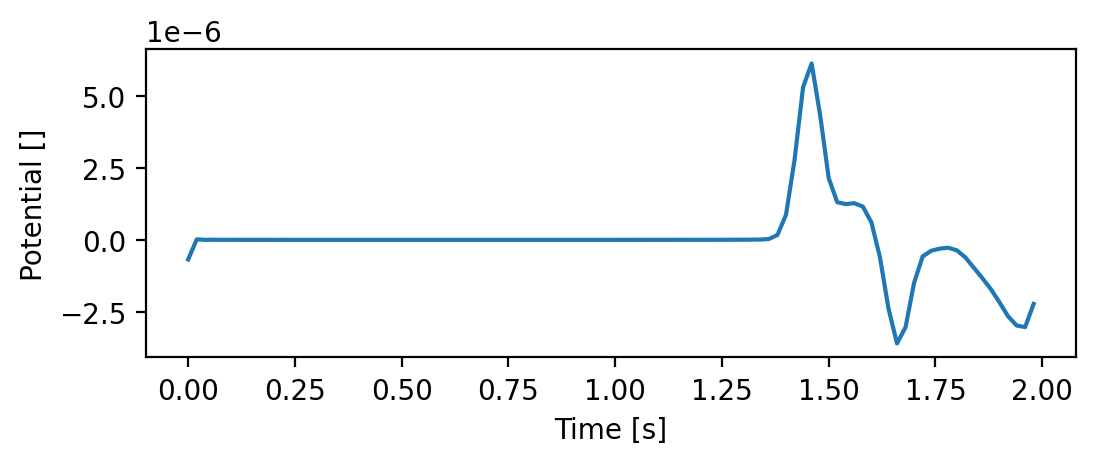

In [51]:
fig = plt.figure(figsize=(6,2),dpi=200)
ax = fig.gca()

ax.plot(stream[0].times(), stream[0].data)
ax.set_ylabel("Potential []")
ax.set_xlabel("Time [s]")



In [45]:
stax

900.0

In [21]:
import shutil
# Move netcdf file
# shutil.copy(RunPath+'/input/box_tomography.nc',NETCDFDir)
shutil.copy(RunPath+'/tools/UnifromEarthCore.bm',NETCDFDir)

'/raid1/TomoNet/Runs/Sample/model0011/UnifromEarthCore.bm'

In [23]:
f = Dataset('../DataSet/CartesianStandardRandomModelStrongSparse0018/seismogram_displacement_SYNBOTTOM.nc', 'r')
time = f.variables['time'][:]
# Potential = f.variables['X'][:]
disp_z = f.variables['disp_z'][:]
coordx = f.variables['x'][:]
coordy = f.variables['y'][:]
coorddepth = f.variables['depth'][:]

In [136]:
len(time), len(disp_z), coordx[0:10], coordy[0:10], coorddepth[0:10]

(2500,
 2500,
 masked_array(data=[400., 400., 400., 400., 400., 400., 400., 400., 400.,
                    400.],
              mask=False,
        fill_value=1e+20),
 masked_array(data=[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              mask=False,
        fill_value=1e+20),
 masked_array(data=[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
                    1000., 1000.],
              mask=False,
        fill_value=1e+20))

Text(0.5, 0, 'Time [s]')

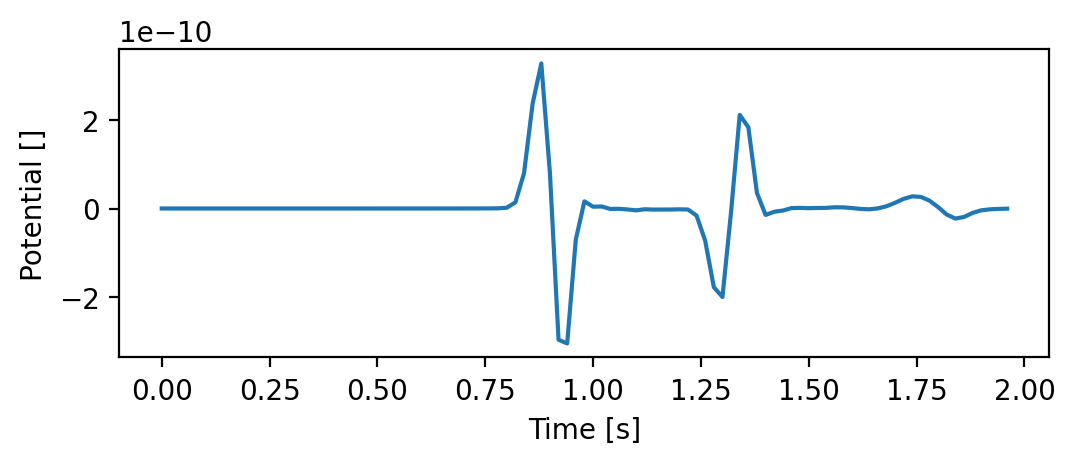

In [24]:
fig = plt.figure(figsize=(6,2),dpi=200)
ax = fig.gca()

# ax.plot(time[0:99], Potential[0:99])
ax.plot(time[0:99], disp_z[0:99])
ax.set_ylabel("Potential []")
ax.set_xlabel("Time [s]")

In [16]:
Potential[-1]

masked